In [44]:
import sys
sys.path.append('../')
from template_project import plotters, tools, utilities, writers, readers
from glidertest import utilities as gtutil
import importlib

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.colors import BoundaryNorm
import palettable as palette
import pandas as pd

# After editing your_module_name.py, reload it:
importlib.reload(plotters)

obsidiandirec = 'C:/Users/m300892/Documents/PhD/Obsidian/PhD/Images/'

In [45]:
# Load gliderdata of churchill (containing w, MLD from a density threshold (0.01) and MLD_manually selected)
ds                  = readers.read_glider('churchill')
# Load ERA5 datasets in the LabSea of years 2021/2022
ds_wind, ds_heat    = readers.read_ERA5()
# Load high pass filtered vertical velocity data from churchill
ds_hp               = readers.read_hp_w()

In [49]:
ds

<xarray.Dataset>
Dimensions:                   (time: 8442480)
Coordinates:
    latitude                  (time) float64 60.52 60.52 60.52 ... 56.67 56.67
    longitude                 (time) float64 -46.34 -46.34 ... -52.61 -52.61
    depth                     (time) float64 -0.208 -0.208 ... 2.982 2.982
  * time                      (time) datetime64[ns] 2021-12-10T13:01:06.55618...
Data variables: (12/28)
    time_ctd                  (time) datetime64[ns] NaT NaT ... NaT
    heading                   (time) float64 5.925 5.93 6.086 ... 1.665 1.665
    pitch                     (time) float64 -0.06981 -0.07057 ... 0.5725 0.5725
    roll                      (time) float64 0.3368 0.3332 ... 0.01396 0.01396
    m_de_oil_vol              (time) float64 258.9 258.9 258.9 ... 260.6 260.7
    conductivity              (time) float64 nan nan nan nan ... nan 3.216 nan
    ...                        ...
    SA                        (time) float64 nan nan nan nan ... nan 34.83 nan
    CT                        (time) float64 nan nan nan nan ... nan 3.862 nan
    sigma1                    (time) float64 nan nan nan nan ... nan 32.14 nan
    sigma0                    (time) float64 nan nan nan nan ... nan 27.54 nan
    MLD                       (time) float64 nan nan nan nan ... -59.0 nan nan
    MLD_manual                (time) float64 nan nan nan nan ... 57.0 nan nan
Attributes: (12/61)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0
    acknowledgement:           Funding from European Union Horizon 2020
    cdm_data_type:             Trajectory
    comment:                   Deployment of TERIFIC2 in Qaqortoq, Greenland ...
    contributor_name:          L Clement, E Frajka Williams, J Mazlan, B Alls...
    ...                        ...
    summary:                   Study deep convection of the Labrador Sea.
    time_coverage_end:         2022-05-29T05:23:06.000000000
    time_coverage_start:       2021-12-10T13:01:06.000000000
    title:                     noc-churchill398-20211210T1301
    transmission_system:       IRRIDIUM
    wmo_id:                    999999

In [46]:

min_perc = 0.01          # Minimum percentage of data within the rolling window at most common resolution
outer_window_min = 20 # Outer window size in minutes
inner_window_min = 5    # Inner window size in minutes
resolution = 2          # Sampling resolution in seconds (needed to calc the minimum number of observations in a rolling window)
glidername= 'L1398'     # Name of the glider

config = {
    "rolling_window_outer"     : f"{outer_window_min}min",           # 6H choosen by Steffen
    "rolling_window_inner"     : f"{inner_window_min}min",           # 1H, choosen by steffen's
    "rolling_min_periods_outer": int(outer_window_min*min_perc*60),  # Minimum number of observations within the outer rolling window (data before: in hours or see inner window)
    "rolling_min_periods_inner": int((inner_window_min/60)*(3600*1/resolution)*min_perc),  # Minimum number of observations within the inner rolling window (data before: in seconds or see most common time difference)
    
    "var"               : 'w',
    "data_in"           : ds, 
    "data_wind"         : ds_wind,
    "data_heat"         : ds_heat,
    "start_time"        : pd.to_datetime('2022-02-01T00:00:00'), 
    "end_time"          : pd.to_datetime('2022-03-01T00:00:00'), 
    "interp_method"     : "linear",
    "depth_min"         : 50,  # Drop upper 50m (wave effects, etc.)
    "max_lag"           : 24 * 3,
    "freq"              : 'H',
    "add_ext_interp"    : False, #True,
    "variables_to_keep" : ['salinity', 'temperature', 'density', 'depth', 'latitude', 'longitude', 'time', 'MLD', 'w', 'profile_direction', 'MLD_manual', 'profile_index'], #if None it keeps the standard variables
}
# Preprocess data
ds_398                                                          = tools.preprocess_data(config)
# Interpolate ERA5 onto hourly positions of the glider
resample_time, series_wind, series_heat                         = tools.interpolate_onto_track(ds_398, config)

# Calculate vertical velocity variance
mld_var = 'MLD_manual' #or 'MLD'
series_w_prime, gap_mask, intermediates                         = tools.get_wprime_timeseries_update_3(resample_time,ds_398, config, debug=True, mld_var=mld_var) # max_gap_duration=np.timedelta64(1, "h"),
# Calculate vertical velocity variance masking just before the interpolation (thus including more values from outside the ML)
series_w_prime_masklater, _ , intermediates_mask_later          = tools.get_wprime_timeseries_update_2(resample_time,ds_398, config, debug=True, mld_var=mld_var)
# Calculate vertical velocity variance without any masking
wprime_rms                                                      = tools.calculate_wprime(ds_398, config, return_mask=False)

filter depths shallower than: 50 dbar


In [50]:
ds_398

<xarray.Dataset>
Dimensions:            (time: 1294663)
Coordinates:
  * time               (time) datetime64[ns] 2022-02-01T00:00:00.922699008 .....
Data variables:
    latitude           (time) float64 56.69 56.69 56.69 ... 56.27 56.27 56.27
    longitude          (time) float64 -51.62 -51.62 -51.62 ... -52.91 -52.91
    temperature        (time) float64 3.501 3.502 3.502 ... 2.957 2.955 2.954
    depth              (time) float64 835.8 836.0 836.2 ... 50.5 50.27 50.05
    salinity           (time) float64 34.85 34.85 34.85 ... 34.74 34.74 34.74
    profile_index      (time) float64 645.0 645.0 645.0 ... 880.0 880.0 880.0
    profile_direction  (time) float64 1.0 1.0 1.0 1.0 ... -1.0 -1.0 -1.0 -1.0
    w                  (time) float64 -0.0007759 0.004152 ... 0.01521 0.01537
    MLD                (time) float64 -238.0 -238.0 -238.0 ... -283.0 -283.0
    MLD_manual         (time) float64 232.9 232.9 232.9 ... 474.3 474.3 474.3
    time_var           (time) int64 1643673600922699008 ... 1646092592941223168
Attributes: (12/61)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0
    acknowledgement:           Funding from European Union Horizon 2020
    cdm_data_type:             Trajectory
    comment:                   Deployment of TERIFIC2 in Qaqortoq, Greenland ...
    contributor_name:          L Clement, E Frajka Williams, J Mazlan, B Alls...
    ...                        ...
    summary:                   Study deep convection of the Labrador Sea.
    time_coverage_end:         2022-05-29T05:23:06.000000000
    time_coverage_start:       2021-12-10T13:01:06.000000000
    title:                     noc-churchill398-20211210T1301
    transmission_system:       IRRIDIUM
    wmo_id:                    999999

In [ ]:
series_w_prime, gap_mask, intermediates                         = tools.get_wprime_timeseries_update_3(resample_time,ds_398, config, debug=True, mld_var=mld_var) #

In [27]:
wG, profG, depthG = gtutil.construct_2dgrid(ds.profile_index, ds.time, ds.w, 1,1)
plt.pcolormesh(profG, depthG,wG)


MemoryError: Unable to allocate 104. PiB for an array with shape (14660520027465985,) and data type datetime64[ns]

In [19]:
intermediates.keys()#['wprime_inner']

dict_keys(['wprime_inner', 'is_nan', 'wprime_in_mld', 'is_below', 'time_leaves_mld', 'time_enters_mld', 'gap_mask', 'wprime_outer', 'wprime_interp_seg'])

In [6]:
# ds_shallow = ds_398.where(((ds_398['depth'] <= 200) & (ds_398['depth'] > 100)) , drop=True) #& (ds_398['depth']>600))
depth_max = 200
ds_mld = ds_398.where((ds_398['depth'] < ds_398['MLD_manual']), drop=True)
ds_shallow = ds_mld.where((ds_mld['depth'] <= depth_max) & (ds_mld['depth']>depth_max-100) , drop=True) #

series_w_prime_shallow, gap_mask, intermediates                         = tools.get_wprime_timeseries_update_3(resample_time,ds_shallow, config, debug=True, mld_var=mld_var) # max_gap_duration=np.timedelta64(1, "h"),
# # Calculate vertical velocity variance without any masking
# wprime_rms_shallow                                                      = tools.get_wprime_timeseries(resample_time, ds_shallow, config, return_mask=False)

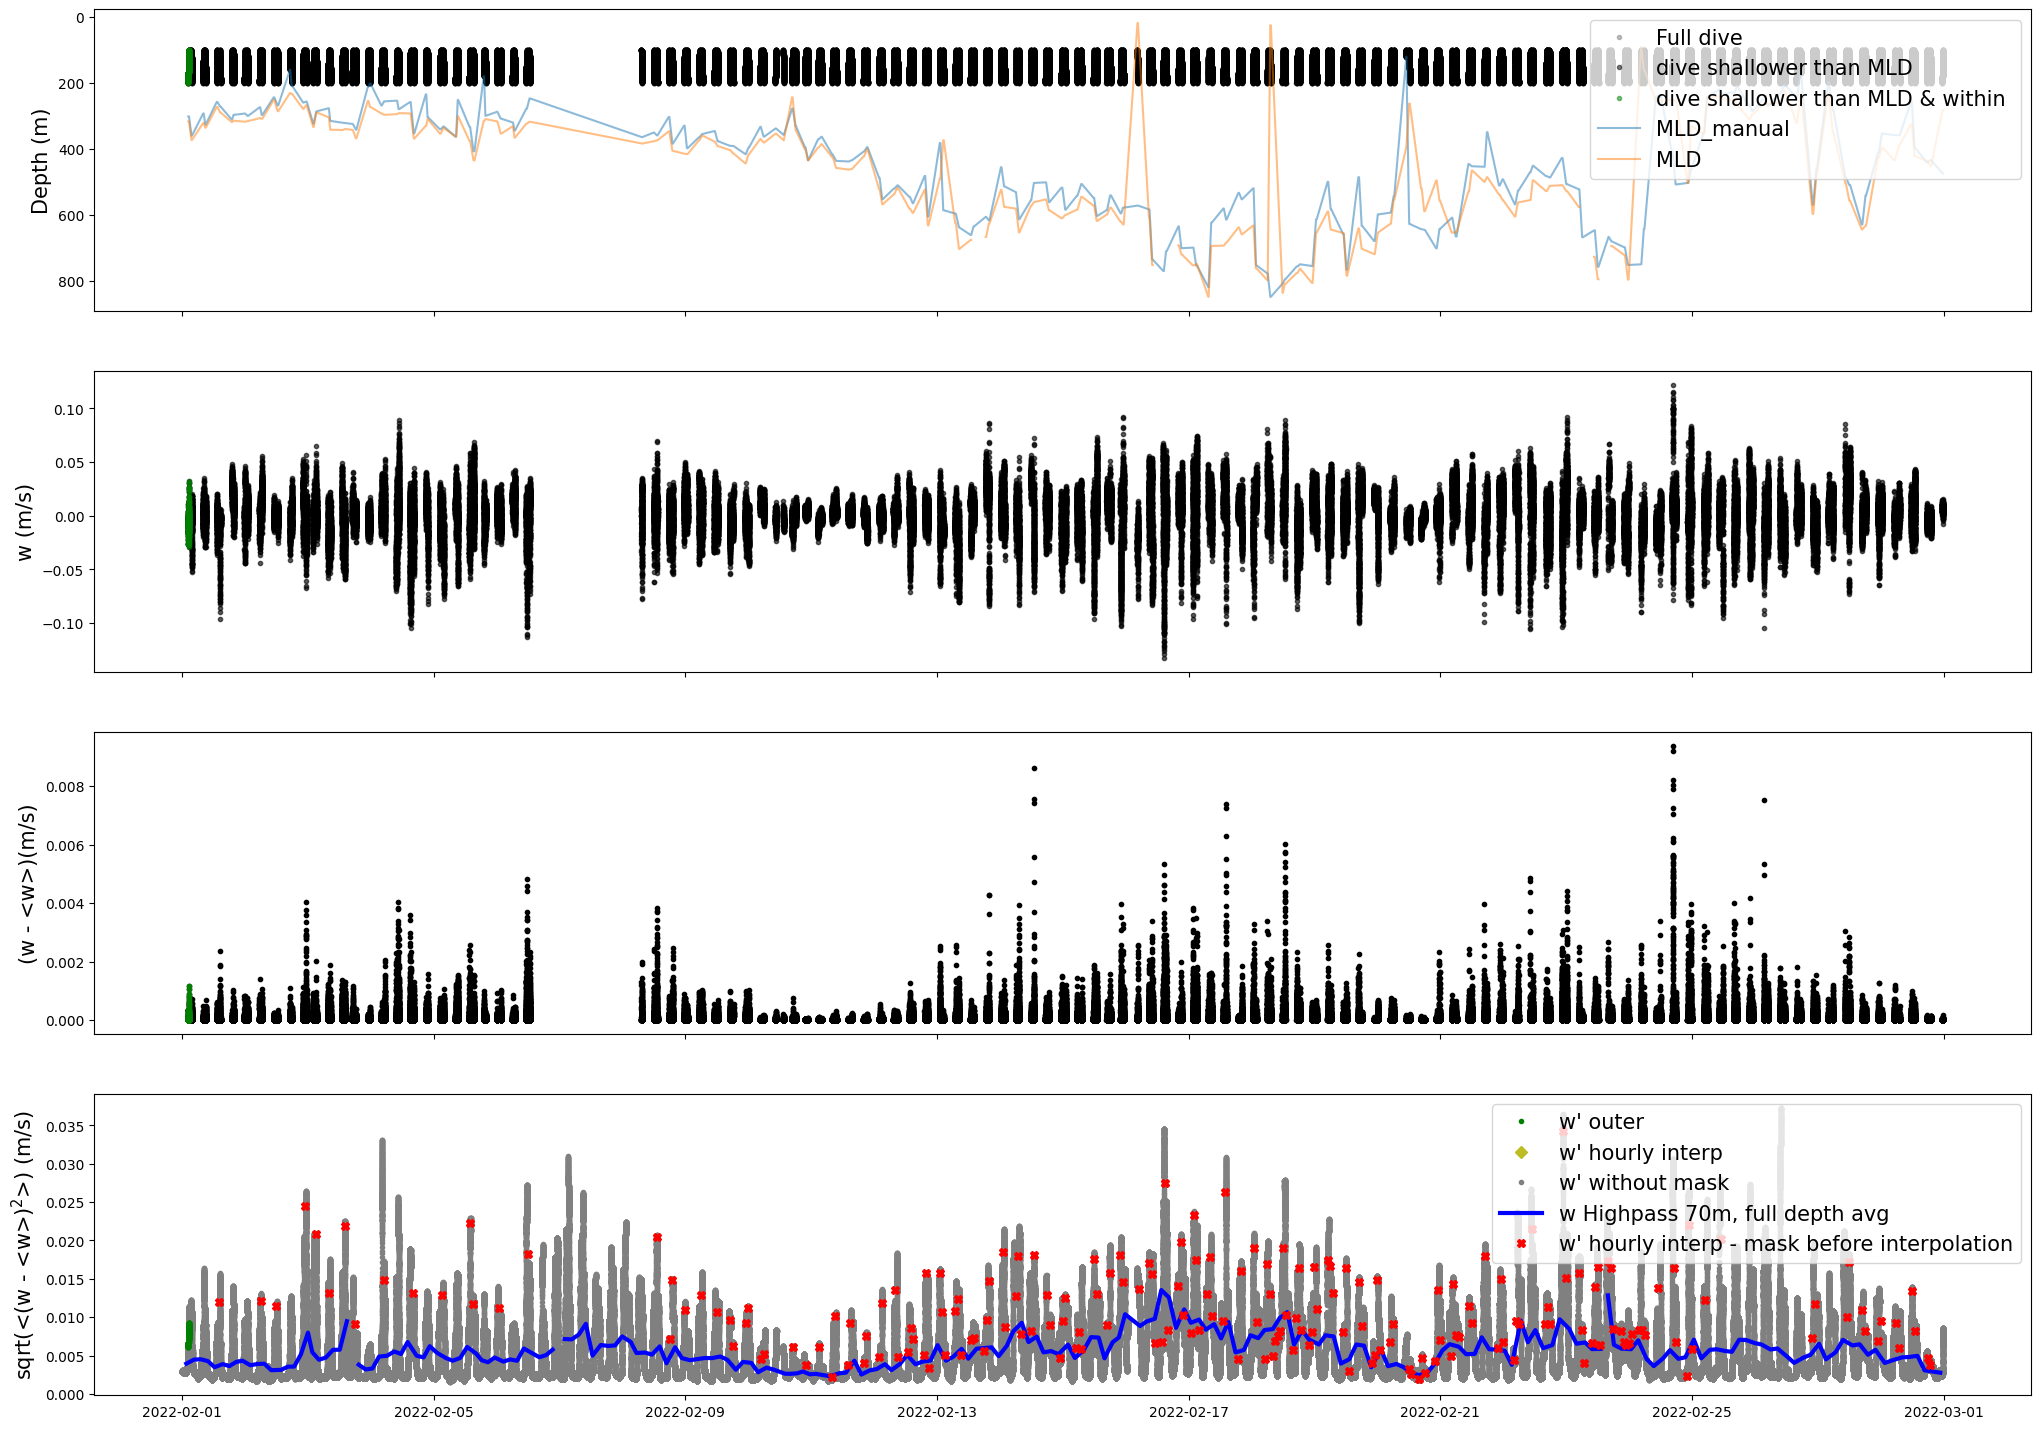

In [7]:
ds_hp_sel = ds_hp.isel({'profile_index' : (ds_hp['mid_times'] >= config['start_time']) & (ds_hp['mid_times'] <= config['end_time'])}, drop=True)
fig, ax = plotters.plot_lag_correlation_steps(intermediates, ds_shallow, 
                                                   wprime_rms=wprime_rms, 
                                                   series_2 = series_w_prime_masklater, 
                                                   ds_hp = ds_hp_sel,
                                                   mld_var=['MLD_manual','MLD'])
# Set x limit to zoom in
#ax[0].set_xlim(config['start_time'], config['end_time'])
# ax[0].set_xlim(pd.to_datetime('2022-03-05T00:00:00'), pd.to_datetime('2022-03-15T00:00:00'))